In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
from tqdm.notebook import tqdm, trange
from tqdm.utils import _term_move_up
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List  # just to help readability

print(torch.__version__)
device_string = 'mps' if torch.backends.mps.is_built() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"MPS Available : {torch.backends.mps.is_built()}")
print (f"CUDA availabe : {torch.cuda.is_available()}")
DEVICE = torch.device(device_string)
print(f"GPU - {DEVICE}")
!jupyter nbextension enable --py widgetsnbextension

2.0.0
MPS Available : True
CUDA availabe : False
GPU - mps
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# looking at activations

Text(0, 0.5, 'ReLU(x)')

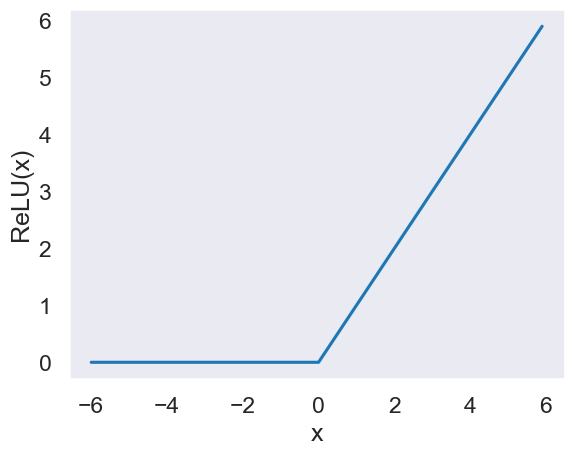

In [2]:
# Set the plot style
sns.set_context("talk")
sns.set_style("dark")
relu = torch.nn.ReLU()
input = torch.arange(-6, 6, step=0.1)
output = relu(input)
sns.lineplot(x=input, y=output)
plt.xlabel("x")
plt.ylabel("ReLU(x)")


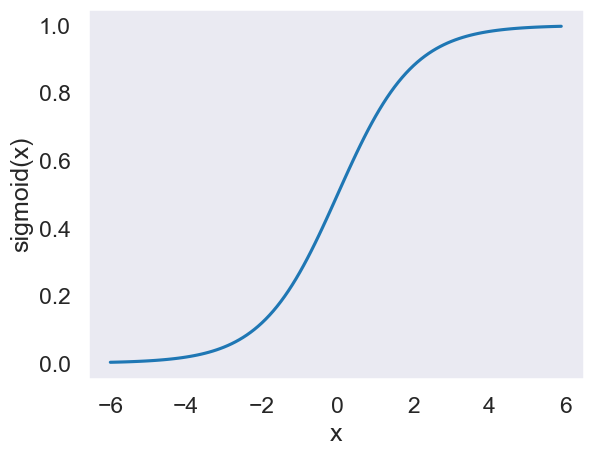

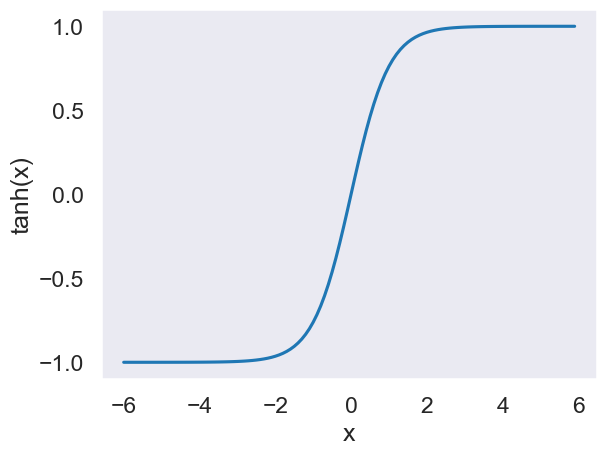

In [3]:
output_sigmoid = torch.nn.Sigmoid()(input)
sns.lineplot(x=input, y=output_sigmoid)
plt.xlabel("x")
plt.ylabel("sigmoid(x)")
plt.show()
output_tanh = torch.nn.Tanh()(input)
sns.lineplot(x=input, y=output_tanh)
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.show()


# MLP

In [2]:
# Generate Model
def create_sequential_model(dim_in: int, dim_out: int, hidden_layer_sizes: List[int]):
    print(dim_in)
    hiddens = [dim_in, *hidden_layer_sizes]
    torch_layers = []
    # Create a linear layer and feed it through a ReLU
    for i in range(len(hiddens) - 1):
        torch_layers.append(torch.nn.Linear(hiddens[i], hiddens[i + 1]))
        torch_layers.append(torch.nn.ReLU())
    torch_layers.append(
        torch.nn.Linear(hiddens[-1], dim_out)
    )  # create the output layer
    return torch.nn.Sequential(*torch_layers)


# CIFAR10 Dataset

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    "./data/CIFAR10/Train",
    train=True,
    download=True,
    transform=tf.Compose(
        [
            tf.ToTensor(),
            tf.Normalize(
                mean=(0.49139968, 0.48215827, 0.44653124),
                std=(0.24703233, 0.24348505, 0.26158768),
            ),
        ]
    ),
)

test_dataset = torchvision.datasets.CIFAR10(
    "./data/CIFAR10/Test",
    train=False,
    download=True,
    transform=tf.Compose(
        [
            tf.ToTensor(),
            tf.Normalize(
                mean=(0.49139968, 0.48215827, 0.44653124),
                std=(0.24703233, 0.24348505, 0.26158768),
            ),
        ]
    ),
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        # self.unf = nn.Unflatten(1, (1,50,37))
        self.cnn_layers = nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(
                in_channels=1, out_channels=16, kernel_size=3, padding=0, stride=1
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # convolutional layer 2
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # convolutional layer 3
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
        # x = self.unf(x)
        x = self.cnn_layers(x)
        # print(x.shape)
        x = self.linear_layers(x)
        return x


cifar_model = CIFAR_CNN()


In [5]:
LR = 1e-3
EPOCHS = 30
# wd = 0.01
loss_fn = nn.CrossEntropyLoss()
model = CIFAR_CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device_string = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
DEVICE = torch.device(device=device_string)


In [6]:
def get_accuracy():
    test_acc = 0
    model.eval()

    with torch.no_grad():
        # Iterating over the training dataset in batches
        for i, (images, labels) in tqdm(enumerate(test_loader)):
            images = images.to(DEVICE)
            y_true = labels.to(DEVICE)

            # Calculating outputs for the batch being iterated
            print(images.shape)
            outputs = model(images)

            # Calculated prediction labels from models
            _, y_pred = torch.max(outputs.data, 1)

            # Comparing predicted and true labels
            test_acc += (y_pred == y_true).sum().item()

        print(f"\rTest set accuracy = {100 * test_acc / len(test_set)} %", end="")
        return 100 * test_acc / len(test_set)


def get_loss():
    train_loss = 0

    # Iterating over the training dataset in batches
    model.train()

    for i, (images, labels) in tqdm(enumerate(train_loader)):
        # Extracting images and target labels for the batch being iterated
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Calculating the model output and the cross entropy loss
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Updating weights according to calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Printing loss for each epoch
    train_loss_list.append(train_loss / len(train_loader))
    print(f"\rTraining loss = {train_loss_list[-1]}", end="")


In [7]:
train_loss_list = []
model = model.to(device=DEVICE)
best_acc = 0
best_epoch = -1
pbar = trange(EPOCHS)
for epoch in pbar:
    print(f"\rEpoch: {epoch}", end="")
    get_loss()
    this_acc = get_accuracy()
    if this_acc > best_acc:
        best_acc = this_acc
        best_epoch = epoch
print(f"Best accuracy occurred at {best_epoch} and was: {best_acc} %")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0

0it [00:00, ?it/s]

RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

In [5]:
cifar_criterion = torch.nn.CrossEntropyLoss(reduction="mean")
cifar_optimiser = torch.optim.Adam(
    cifar_model.parameters(), lr=learning_rate
)  # model.parameters gives the weight matrices and biases to the optimiser (AKA trainable parameters)

cifar_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=cifar_optimiser,
    milestones=[300, 500, 800],
    gamma=0.5,
)


In [13]:
# train test loop
pbar = trange(optimisation_steps)

cifar_metrics = []
for i in pbar:
    cifar_model.to(DEVICE)
    idx = np.random.randint(
        0, cifar_training_data.shape[0], size=batch_size
    )  # random sample of batch_size indices from 0 to the number of datapoints the dataset has
    x = torch.from_numpy(
        cifar_training_data[idx, :]
    )  # get the datapoints at the sampled indices
    x = x.to(DEVICE)
    # flattened_x = torch.from_numpy(x.reshape(batch_size,-1)).as # flatten the datapoints
    y_pred = cifar_model(x)  # predict the classes of the datapoints)
    cifar_loss = cifar_criterion(
        y_pred, torch.from_numpy(cifar_training_labels[idx]).to(DEVICE)
    )  # compute the loss by comparing the predicted labels vs the actual labels
    # zero the gradients held by the optimiser
    cifar_optimiser.zero_grad()
    # perform a backward pass to compute the gradients
    cifar_loss.backward()
    # update the weights
    cifar_optimiser.step()
    if i % 100 == 99:
        if i % 1000 == 999:
            train_pred = cifar_model(torch.from_numpy(cifar_training_data).to(DEVICE))
            val_pred = cifar_model(torch.from_numpy(cifar_validation_data).to(DEVICE))
            cifar_train_accuracy = torch.mean(
                (
                    train_pred.argmax(dim=1)
                    == torch.from_numpy(cifar_training_labels).to(DEVICE)
                ).float()
            )
            cifar_val_accuracy = torch.mean(
                (
                    val_pred.argmax(dim=1)
                    == torch.from_numpy(cifar_validation_labels).to(DEVICE)
                ).float()
            )
            # print the loss every 100 steps
            cifar_metrics.append(
                [
                    i,
                    cifar_loss.item(),
                    cifar_train_accuracy.cpu().numpy(),
                    cifar_val_accuracy.cpu().numpy(),
                ]
            )
        print(f"\rEpoch: {i} Loss:{round(cifar_loss.item(),2)}", end="")
    cifar_scheduler.step()


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 9999 Loss:2.33

In [ ]:
# train test loop
pbar = trange(optimisation_steps)

cifar_metrics = []
for i in pbar:
    cifar_model.to(DEVICE)


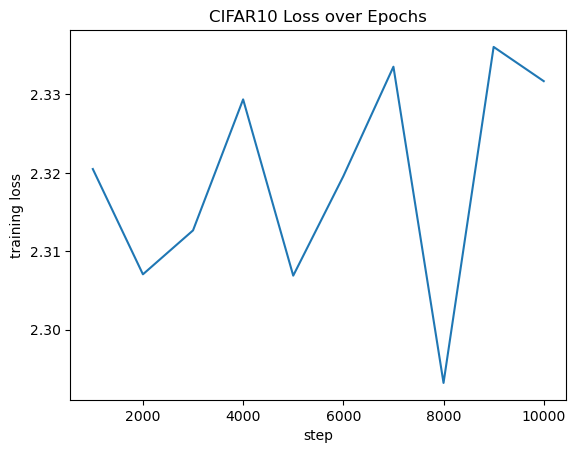

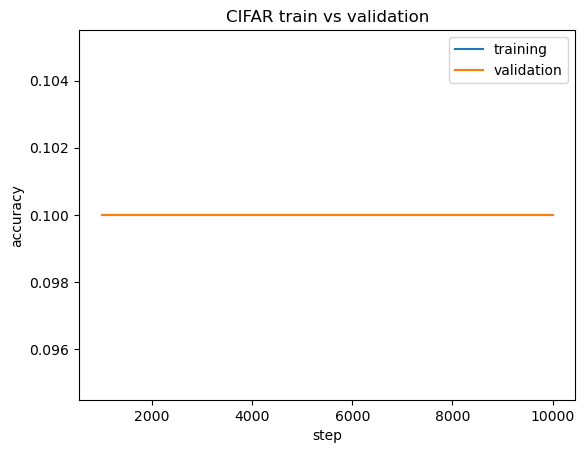

In [14]:
cifar_metrics = np.asarray(cifar_metrics)
sns.lineplot(x=cifar_metrics[:, 0], y=cifar_metrics[:, 1])
plt.title("CIFAR10 Loss over Epochs")
plt.xlabel("step")
plt.ylabel("training loss")
plt.show()
sns.lineplot(x=cifar_metrics[:, 0], y=cifar_metrics[:, 2], label="training")
sns.lineplot(x=cifar_metrics[:, 0], y=cifar_metrics[:, 3], label="validation")
plt.title("CIFAR train vs validation")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.show()


# MNIST dataset

In [22]:
MNIST_train = torchvision.datasets.MNIST(
    "MNIST_data", download=True, train=True, transform=True
)
MNIST_validation = torchvision.datasets.MNIST(
    "MNIST_data", download=True, train=False, transform=True
)
print(MNIST_train.data.shape)
print(len(MNIST_train.classes))
mnist_training_data = (
    MNIST_train.data.reshape((-1, 28 * 28)) / 255.0
)  # flatten the dataset and normalise
mnist_training_labels = np.asarray(MNIST_train.targets)
mnist_validation_data = (
    MNIST_validation.data.reshape((-1, 28 * 28)) / 255.0
)  # flatten the dataset and normalise
mnist_validation_labels = np.asarray(MNIST_validation.targets)


torch.Size([60000, 28, 28])
10


In [23]:
mnist_model = create_sequential_model(28 * 28, 10, [100, 100])


784


In [24]:
# hyperparams

learning_rate = 5e-1  # starting learning rate that we can tweak to increase performance
batch_size = 256  # the number of datapoints per batch that we do
optimisation_steps = int(2e4)  # the number of batches that we train on


In [25]:
mnist_criterion = torch.nn.CrossEntropyLoss(reduction="mean")
mnist_optimiser = torch.optim.SGD(
    mnist_model.parameters(), lr=learning_rate
)  # model.parameters gives the weight matrices and biases to the optimiser (AKA trainable parameters)

mnist_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=mnist_optimiser,
    milestones=[3000, 5000, 8000, 18000, 28000, 38000, 58000],
    gamma=0.5,
)


In [26]:
# train test loop
pbar = trange(optimisation_steps)

mnist_metrics = []
for i in pbar:
    idx = np.random.randint(
        0, mnist_training_data.shape[0], size=batch_size
    )  # random sample of batch_size indices from 0 to the number of datapoints the dataset has
    x = mnist_training_data[idx, :]  # get the datapoints at the sampled indices
    # flattened_x = torch.from_numpy(x.reshape(batch_size,-1)) # flatten the datapoints
    y_pred = mnist_model(x)  # predict the classes of the datapoints)
    mnist_loss = mnist_criterion(
        y_pred, torch.from_numpy(mnist_training_labels[idx])
    )  # compute the loss by comparing the predicted labels vs the actual labels
    # zero the gradients held by the optimiser
    mnist_optimiser.zero_grad()
    # perform a backward pass to compute the gradients
    mnist_loss.backward()
    # update the weights
    mnist_optimiser.step()
    if i % 100 == 99:
        if i % 1000 == 999:
            train_pred = mnist_model(mnist_training_data)
            val_pred = mnist_model(mnist_validation_data)
            mnist_train_accuracy = torch.mean(
                (
                    train_pred.argmax(dim=1) == torch.from_numpy(mnist_training_labels)
                ).float()
            )
            mnist_val_accuracy = torch.mean(
                (
                    val_pred.argmax(dim=1) == torch.from_numpy(mnist_validation_labels)
                ).float()
            )
            # print the loss every 100 steps
            mnist_metrics.append(
                [
                    i,
                    mnist_loss.item(),
                    mnist_train_accuracy.numpy(),
                    mnist_val_accuracy.numpy(),
                ]
            )
        print(f"\rEpoch: {i} Loss:{round(mnist_loss.item(),2)}", end="")
    mnist_scheduler.step()


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch: 19999 Loss:0.0

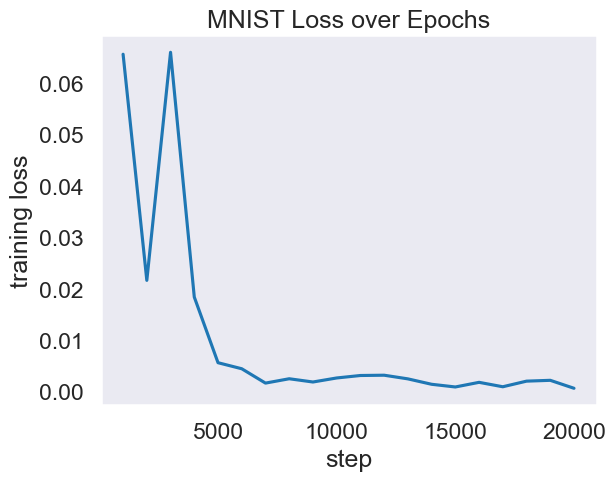

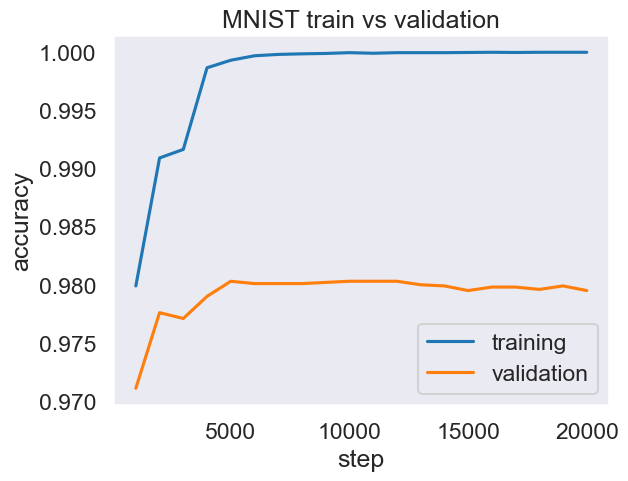

In [27]:
mnist_metrics = np.asarray(mnist_metrics)
sns.lineplot(x=mnist_metrics[:, 0], y=mnist_metrics[:, 1])
plt.title("MNIST Loss over Epochs")
plt.xlabel("step")
plt.ylabel("training loss")
plt.show()
sns.lineplot(x=mnist_metrics[:, 0], y=mnist_metrics[:, 2], label="training")
sns.lineplot(x=mnist_metrics[:, 0], y=mnist_metrics[:, 3], label="validation")
plt.title("MNIST train vs validation")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.show()


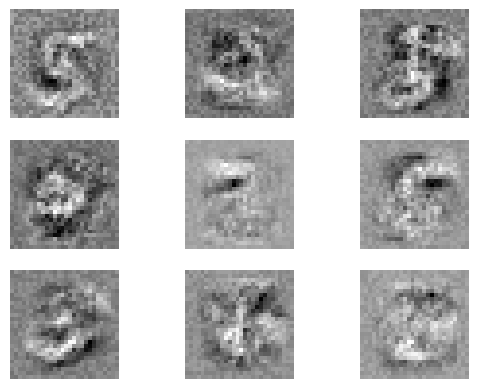

In [ ]:
# assuming the weight matrix is named "W" and has shape (num_neurons, num_inputs)
weights = mnist_model[0].weight.data

# plot the first 9 rows of the weight matrix as images
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(weights[i * 3 + j].reshape(28, 28), cmap="gray")
        axs[i, j].axis("off")
plt.show()
